In [272]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

## Notebook guide

In this notebook we collect some common steps that we might need to follow whilst tackling a classification problem using pandas and scikit-learn. 

The goal is not to find the best model (in fact we only try 1 logistic regression model), but just to clear out some fog on steps to follow in an ML scenario.

The steps in this notebook are: 

1. Data Exploration: simple data exploration to understand variable types, correlation and if the dataset is balanced in term of classes
2. Data Cleansing: we check for missing values and outliers
3. Train-test split and finding a baseline: we throw a logistic regression model at the full dataset to find a baseline that we can use to compare against in the rest of the notebook
4. Feature engineering: this is actually not feature engineering, but only some feature selection using Lasso. We also talk about cross validation, stratified cross validation (to keep the balance amongst classes) and hyperparameter tuning. We also look into validation curves 
5. Evaluating the trained model: we check the performance of the model using different tool proper of a classification problem. 

The dataset is quite small and it's difficult to see proper results for the cross valiation part, but the concepts covered are important to grasp. It was a good excercise to practice some of the theoretical concepts learned. 

## Data Exploration

In [3]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [7]:
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

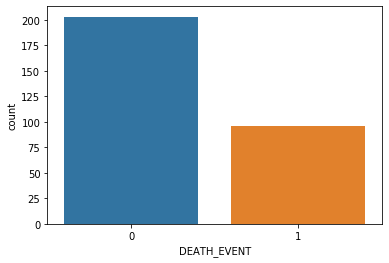

In [9]:
sns.countplot(df['DEATH_EVENT']); # we use countplot here because we have a discrete variable

Detecting correlation between variables through the correlation matrix.

If we find multicollinearity (independent variables strongly correlated to each other), we can drop those variables 
during regularization.

The heatmap will show us which independent variables are most correlated with the dependent one

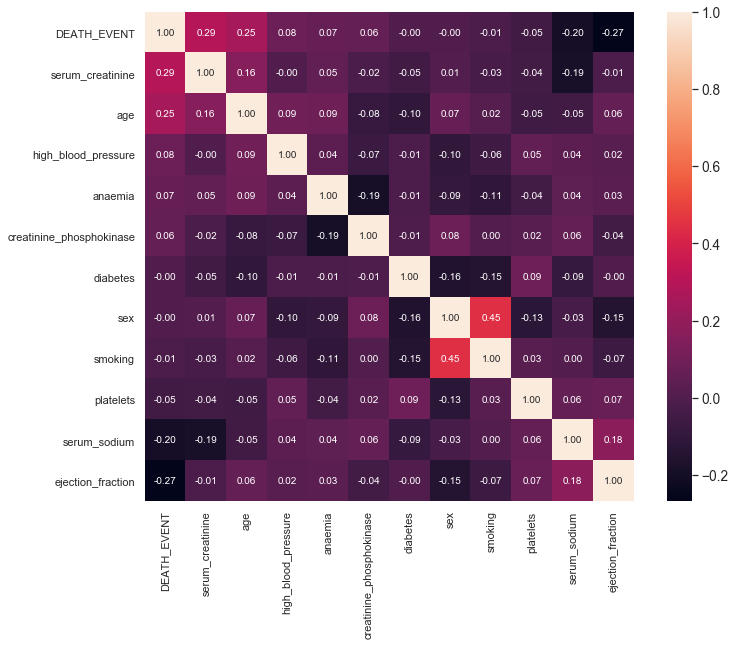

In [25]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
k = 12 #number of variables for heatmap
cols = corrmat.nlargest(k, 'DEATH_EVENT')['DEATH_EVENT'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

The pairs plot builds on two basic figures, the histogram and the scatter plot. The histogram on the diagonal allows us to see the distribution of a single variable while the scatter plots on the upper and lower triangles show the relationship (or lack thereof) between two variables.

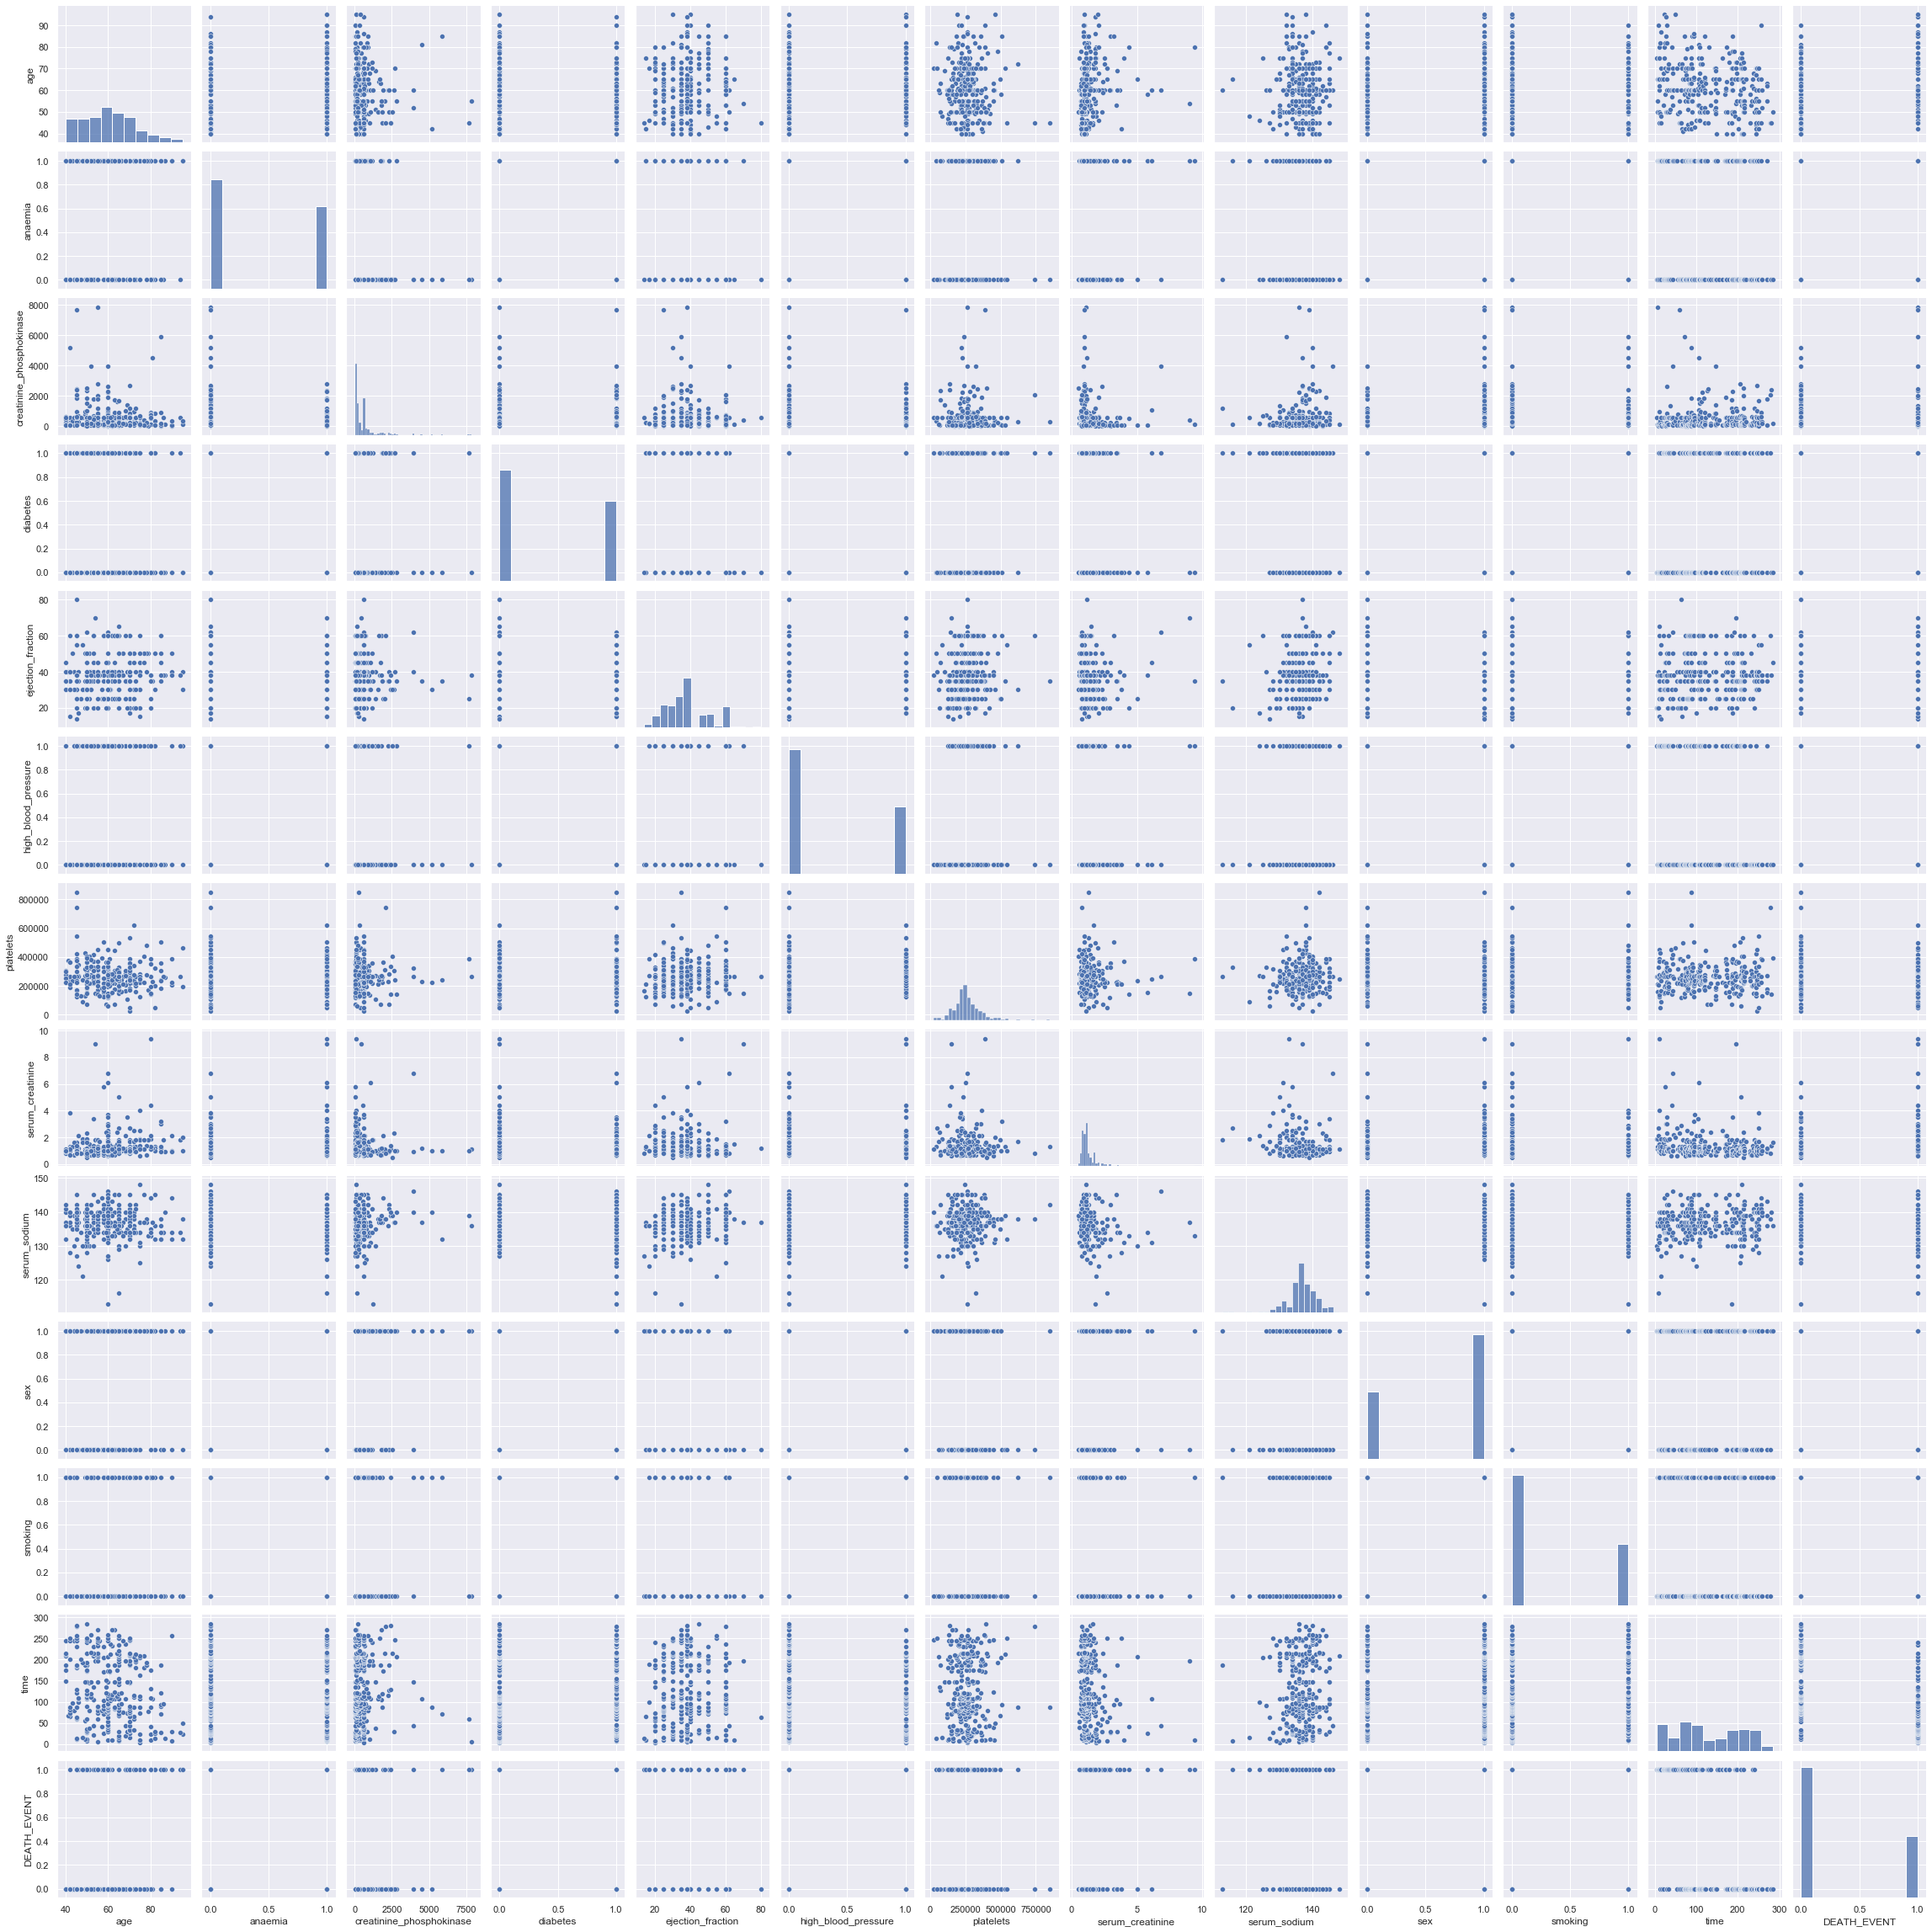

In [16]:
#scatterplot
sns.set()
sns.pairplot(df, size = 2.5)
plt.show();

Let's say we want a pairplot with only the most correlated variables to our Y. We can apply a filtering strategy like the below.

In [38]:
cor_target = abs(df.corr()["DEATH_EVENT"])
relevant_features = cor_target[cor_target>0.2]
relevant_features


age                  0.253729
ejection_fraction    0.268603
serum_creatinine     0.294278
time                 0.526964
DEATH_EVENT          1.000000
Name: DEATH_EVENT, dtype: float64

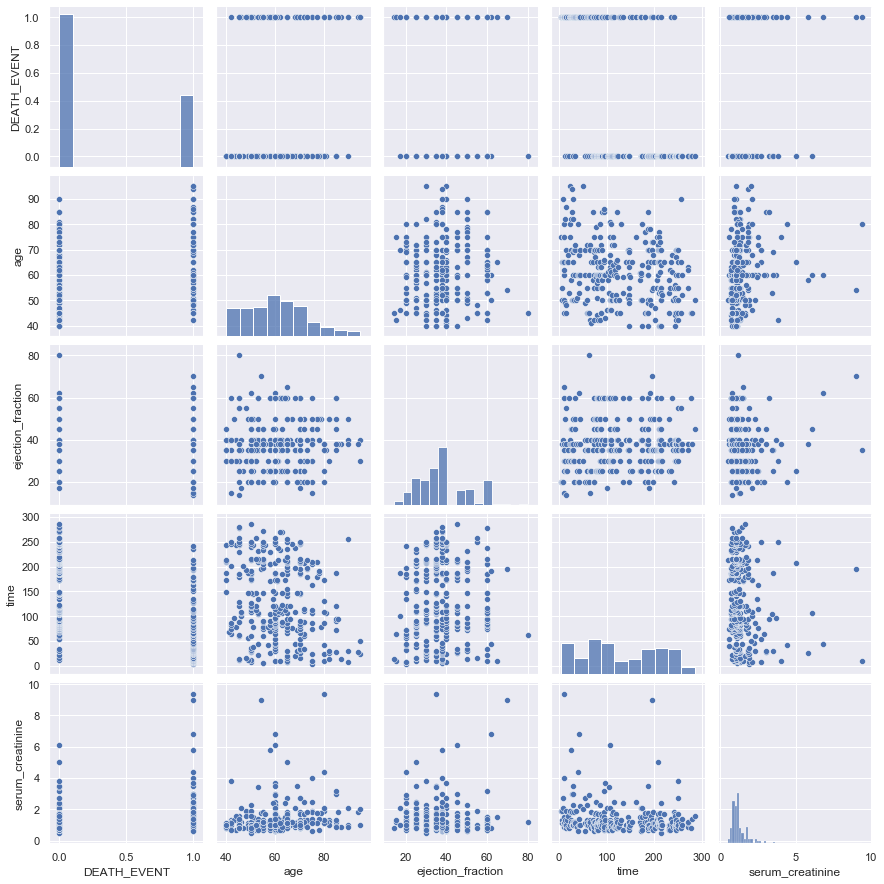

In [266]:
# pairplot
sns.set()
cols = ["DEATH_EVENT", "age", "ejection_fraction", "time", "serum_creatinine"]
sns.pairplot(df[cols], size = 2.5)
plt.show();

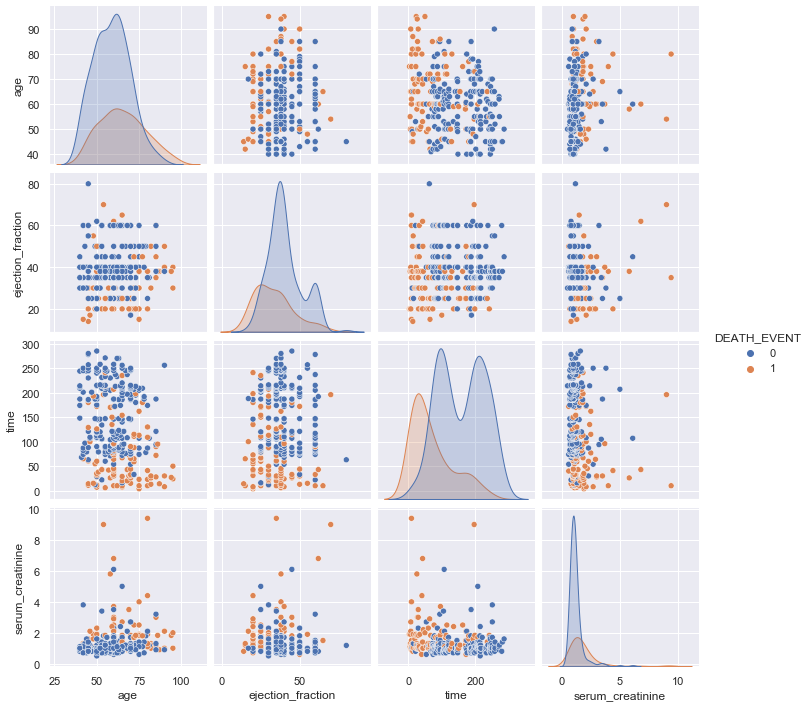

In [43]:
# scatterplot
sns.set()
cols = ["DEATH_EVENT", "age", "ejection_fraction", "time", "serum_creatinine"]
sns.pairplot(df[cols], size = 2.5, hue="DEATH_EVENT")
plt.show();

## Data Cleansing

In [45]:
df.isnull().values.any() # do we have missing values?

False

We now check for outliers. We can either use histograms, boxplots or scatterplots

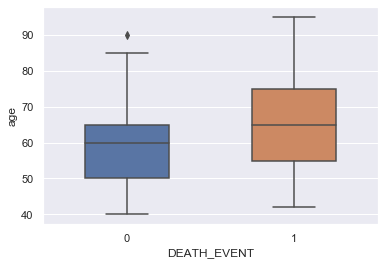

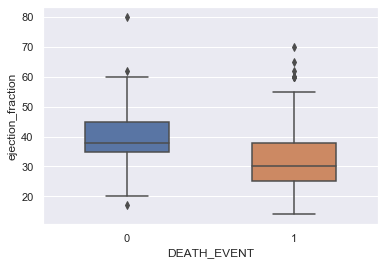

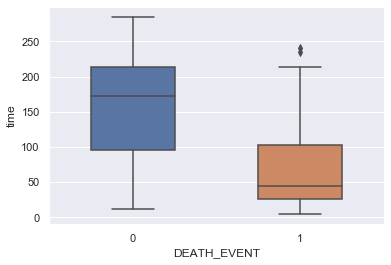

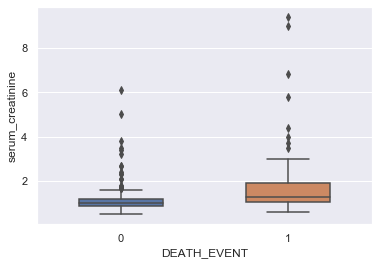

In [67]:
cols = ["age", "ejection_fraction", "time", "serum_creatinine"]
i = 0
for col in cols: 
    plt.figure(i)
    sns.boxplot(y=col, x='DEATH_EVENT', data=df, width=0.5)
    i += 1

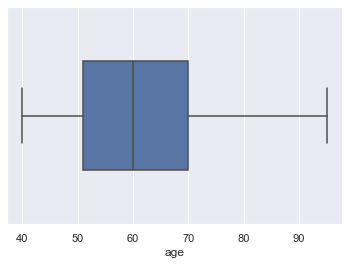

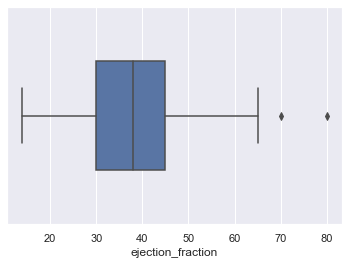

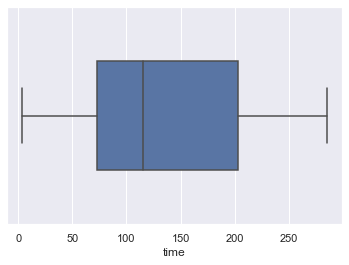

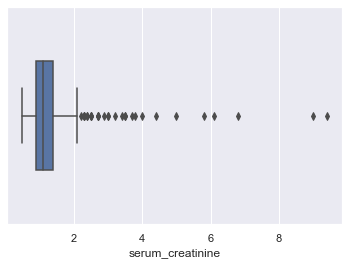

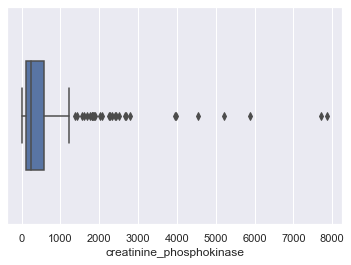

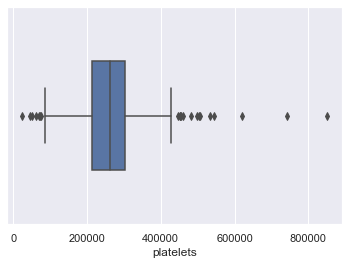

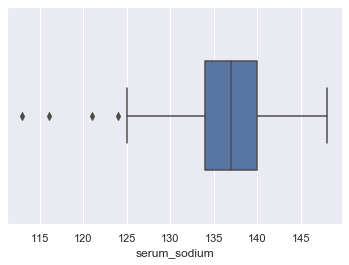

In [70]:
cols = ["age", "ejection_fraction", "time", "serum_creatinine", "creatinine_phosphokinase", "platelets",
       "serum_sodium"]
for col in list(cols): 
    plt.figure(i)
    sns.boxplot(x=col, data=df, width=0.5)
    i += 1

The box plots shows there are some outliers. I would need to find a way to remove outliers properly. 

[TO EXPAND, study more here: https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/]

## Train test split + setting a baseline for the model

In [273]:
y = pd.DataFrame(df["DEATH_EVENT"])
X = df.loc[:, df.columns != "DEATH_EVENT"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [278]:
logreg_clf = LogisticRegression()
logreg_clf.fit(X_train, y_train)
test_score = logreg_clf.score(X_test, y_test)

print(f"Score is: {score}")

predictions = logreg_clf.predict(X_test)
acc_score = accuracy_score(y_test, predictions)
print(f"Confirming score with sklearn.metrics: {acc_score}")

Score is: 0.6779661016949152
Confirming score with sklearn.metrics: 0.7676767676767676


In [275]:
target_names = ["death", "no death"]
print(classification_report(y_test, predictions, target_names=target_names))


              precision    recall  f1-score   support

       death       0.73      0.95      0.82        57
    no death       0.88      0.52      0.66        42

    accuracy                           0.77        99
   macro avg       0.80      0.74      0.74        99
weighted avg       0.79      0.77      0.75        99



In [279]:
train_score = logreg_clf.score(X_train, y_train)

print(f"Train score {train_score} vs Test score {test_score}")

Train score 0.87 vs Test score 0.7676767676767676


So by simply applying a logistic regression using all variables, we obtain the baseline above. We can see that the model is slightly overfitting the training set. 

## Feature Engineering

The idea here is to keep the same model and do some regularization and try again to train with a smaller number of features.  

### Feature selection and cross-validation

1 - we implement a Lasso feature selection


In [141]:
logistic_l1_reg = LogisticRegression(penalty="l1",solver='liblinear', random_state=7).fit(X_train, y_train)
model = SelectFromModel(logistic_l1_reg, prefit=True)

X_train_selected_features = model.transform(X_train) 

print(f"Original shape for training: {X_train.shape}")
print(f"Shape after L1 for training: {X_train_selected_features.shape}")

col_indices = model.get_support(indices=True) # this returns the indices of the feature that we kept.

print(f"Features we want to keep have indices {col_indices}")

Original shape for training: (200, 12)
Shape after L1 for training: (200, 9)
Features we want to keep have indices [ 0  1  2  3  4  7  8  9 11]


2 - we transform our X_test so that we keep only the important features


In [142]:
X_test_selected_features = X_test.iloc[:, col_indices]

print(f"Shape after L1 feature selection on test data: {X_test_selected_features.shape}")

Shape after L1 feature selection on test data: (99, 9)


3 - we train a model using the selected features and we evaluate the results

In [146]:
logistic_reduced_features = LogisticRegression()
logistic_reduced_features.fit(X_train_selected_features, y_train)
score = logistic_reduced_features.score(X_test_selected_features, y_test)

print(f"Score is: {score}")

predictions = logistic_reduced_features.predict(X_test_selected_features)
accuracy_score = accuracy_score(y_test, predictions)
print(f"Confirming score with sklearn.metrics: {accuracy_score} \n")

target_names = ["death", "no death"]
print(classification_report(y_test, predictions, target_names=target_names))

Score is: 0.797979797979798
Confirming score with sklearn.metrics: 0.797979797979798 

              precision    recall  f1-score   support

       death       0.77      0.93      0.84        57
    no death       0.87      0.62      0.72        42

    accuracy                           0.80        99
   macro avg       0.82      0.77      0.78        99
weighted avg       0.81      0.80      0.79        99



4 - we check train vs test performance (this will tell use if we are overfitting or underfitting)

In [148]:
train_score = logistic_reduced_features.score(X_train_selected_features, y_train)
test_score = logistic_reduced_features.score(X_test_selected_features, y_test)

print(f"Train score {train_score} vs Test score {test_score}")

Train score 0.86 vs Test score 0.797979797979798


### Digging into validation curves

Can we do better with feature selection? We can try to implement hyperparameter tuning to tweak the feautre selection params, select different featuers and train and score different models.

Before going into HPT, we will train to evaluate our model in term of validation curve by varying one of its parameters and analysisng how the curve change by changing that param.

For the purpose of showing how validation curve works, we are going to use the solver as the parameter to tweak. 
We also need to choose the metrics we want to optimise for (i.e accuracy, roc_auc).

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.9s finished


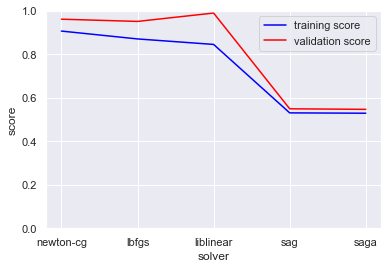

In [179]:
param_range = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
train_scores, test_scores = validation_curve(LogisticRegression(), X, y, param_name="solver", param_range=param_range,
    scoring="roc_auc", verbose=1)

plt.plot(param_range, np.median(train_scores, 1), color='blue', label='training score')
plt.plot(param_range, np.median(test_scores, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('solver')
plt.ylabel('score');

We can do the same with parameters that allow us to tune l1 parameters. 

**Note**: the valiadtion score is higher here because it could be related to the dataset being very tiny. 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.4s finished


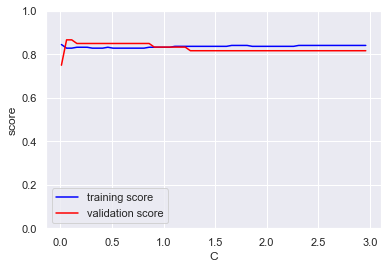

In [185]:
param_range = np.arange(0.01, 3, 0.05)

train_scores, val_scores = validation_curve(LogisticRegression(penalty="l1",solver='liblinear', random_state=7), X, y, param_name="C", param_range=param_range,
    scoring="accuracy", verbose=1)

plt.plot(param_range, np.median(train_scores, 1), color='blue', label='training score')
plt.plot(param_range, np.median(val_scores, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('C')
plt.ylabel('score');

We can try to have the maximum number of features selected for the model to tune

Since we have a small dataset, we are going to use K-fold cross validation.

In [194]:
log_mdl = LogisticRegression(penalty="l1",solver='liblinear', random_state=7)
scores = cross_val_score(log_mdl, X, y, cv=5)
# you can also pass custom scoring metrics, i.e: scores = cross_val_score(log_mdl, X, y, cv=5, scoring="roc_auc")
print(f"accuracy {scores.mean()} with a standard deviation of {scores.std()}")


accuracy 0.7889265536723163 with a standard deviation of 0.11239933732595067


Since the target clases are quite unbalanced, we shoud actually using stratifiedKfold to preserve the same percentage of samples of each target class as the complete set. 

In [228]:
skf = StratifiedKFold(n_splits=5)

cv_score =[]
i=1
for train_index, test_index in skf.split(X,y):
    print(f"{i} of KFold {skf.n_splits}")
    x_train,x_val = X.loc[train_index],X.loc[test_index]
    y_train,y_val = y.loc[train_index],y.loc[test_index]
    
    #model
    lr = LogisticRegression(penalty="l1",solver='liblinear', random_state=7)
    lr.fit(x_train,y_train)    
    score = accuracy_score(y_val, lr.predict(x_val))
    print(f"Accuracy score: {score}")
    cv_score.append(score)    
    i+=1

1 of KFold 5
Accuracy score: 0.6333333333333333
2 of KFold 5
Accuracy score: 0.8333333333333334
3 of KFold 5
Accuracy score: 0.9
4 of KFold 5
Accuracy score: 0.9
5 of KFold 5
Accuracy score: 0.6779661016949152


Now let's try to change the parameters whilst doing cross validation and see what is the best performing model.

We need to define:
 - an estimator 
 - a parameter space
 -  a method for searching or sampling candidates;
 - a cross-validation scheme
 - a score function

In [235]:
def do_cross_validation_on_feature_selection():
    
    y = pd.DataFrame(df["DEATH_EVENT"])
    X = df.loc[:, df.columns != "DEATH_EVENT"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    skf = StratifiedKFold(n_splits=5)

    cv_score = {}
    i=1
    
    for m in range (1,10):
        for train_index, test_index in skf.split(X_train, y_train):
            x_tr,x_val = X.loc[train_index],X.loc[test_index]
            y_tr,y_val = y.loc[train_index],y.loc[test_index]

            # we select the number of features
            lr = LogisticRegression(penalty="l1",solver='liblinear', random_state=7).fit(x_tr, y_tr)
            model = SelectFromModel(lr, prefit=True, max_features=m)
            x_tr_selected_features = model.transform(x_tr)
            # using col_indices to reshape x_val
            col_indices = model.get_support(indices=True)
            feature_size = len(col_indices)
            x_val_selected_features = x_val.iloc[:, col_indices]

            # we train the model on the selected features and evalaute against the validation set
            lr_reduced_features = LogisticRegression(penalty="l1",solver='liblinear', random_state=7)
            lr_reduced_features.fit(x_tr_selected_features, y_tr)
            acc_score = accuracy_score(y_val, lr_reduced_features.predict(x_val_selected_features))
            print(f"Feature size: {feature_size}, score: {acc_score}")
            if feature_size in cv_score:
                cv_score[feature_size].append(acc_score)
            else:
                cv_score[feature_size] = [acc_score]            
            
            i+=1
    
    print("Calculating aggregated stats\n")
    # compute mean of score by feature size
    for feature_size in cv_score:
        print(f"Mean for feature_size {feature_size} is {np.mean(cv_score[feature_size])}")
            

In [236]:
do_cross_validation_on_feature_selection()

Feature size: 1, score: 0.1
Feature size: 1, score: 0.45
Feature size: 1, score: 0.725
Feature size: 1, score: 0.8
Feature size: 1, score: 0.725
Feature size: 2, score: 0.275
Feature size: 2, score: 0.45
Feature size: 2, score: 0.75
Feature size: 2, score: 0.8
Feature size: 2, score: 0.725
Feature size: 3, score: 0.45
Feature size: 3, score: 0.425
Feature size: 3, score: 0.75
Feature size: 3, score: 0.8
Feature size: 3, score: 0.725
Feature size: 4, score: 0.45
Feature size: 4, score: 0.6
Feature size: 4, score: 0.725
Feature size: 4, score: 0.875
Feature size: 4, score: 0.7
Feature size: 5, score: 0.6
Feature size: 5, score: 0.775
Feature size: 5, score: 0.675
Feature size: 5, score: 0.7
Feature size: 5, score: 0.75
Feature size: 6, score: 0.65
Feature size: 6, score: 0.75
Feature size: 6, score: 0.725
Feature size: 6, score: 0.875
Feature size: 6, score: 0.7
Feature size: 7, score: 0.65
Feature size: 7, score: 0.75
Feature size: 7, score: 0.7
Feature size: 7, score: 0.875
Feature siz

Looking at the above, it seems that the best number of features is 6. We could also consider 8, but then at that point the model might be too complicated and overfit.

We are going to train a final model with 6 and 8 features and compare the results on the test set and evaluate underfit or overfit

In [255]:
def train_model(n_features):
    y = pd.DataFrame(df["DEATH_EVENT"])
    X = df.loc[:, df.columns != "DEATH_EVENT"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    lr = LogisticRegression(penalty="l1",solver='liblinear', random_state=7).fit(X_train, y_train)
    model = SelectFromModel(lr, prefit=True, max_features=n_features)
    X_train_selected_features = model.transform(X_train)
    col_indices = model.get_support(indices=True)
    X_test_selected_features = X_test.iloc[:, col_indices]
    
    model_lr = LogisticRegression(penalty="l1",solver='liblinear', random_state=7)
    model_lr.fit(X_train_selected_features, y_train)
    train_score = accuracy_score(y_train, model_lr.predict(X_train_selected_features))
    test_score = accuracy_score(y_test, model_lr.predict(X_test_selected_features))
    
    print(f"Train score: {train_score}, test score: {test_score}")
    
    return X_train_selected_features, X_test_selected_features, y_train, y_test, model_lr
    

In [256]:
X_train, X_test, y_train, y_test, model_six_features = train_model(6)
X_train, X_test, y_train, y_test, model_eight_features = train_model(8)

Train score: 0.82, test score: 0.6565656565656566
Train score: 0.86, test score: 0.797979797979798


It looks like we are underfitting with 6 features. 8 features lead to better results at test time

## Evaluating the trained model

Now that we have a trained model. We can look at some of its metrics. We are going to look at the confusion matrix, classification report and the area under the ROC curve-

[[53  4]
 [16 26]]


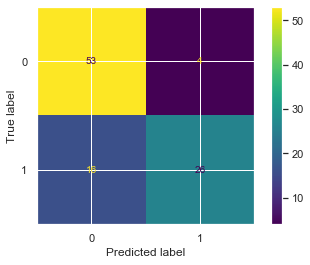

In [262]:
predictions = model_eight_features.predict(X_test)
print(confusion_matrix(y_test, predictions))
plot_confusion_matrix(model_eight_features, X_test, y_test)  
plt.show()  


In [263]:
target_names = ["death", "no death"]
print(classification_report(y_test, predictions, target_names=target_names))


              precision    recall  f1-score   support

       death       0.77      0.93      0.84        57
    no death       0.87      0.62      0.72        42

    accuracy                           0.80        99
   macro avg       0.82      0.77      0.78        99
weighted avg       0.81      0.80      0.79        99



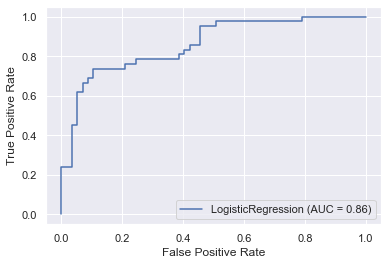

In [265]:
plot_roc_curve(model_eight_features, X_test, y_test)